In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 21.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612223 sha256=b5897b5ba4862ff8a89fc353fa8dc42bdcfb046cb25dcd5b45ad1a3886c4bd21
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder\
        .master("local[*]")\
        .appName('BooksAnalysis')\
        .getOrCreate()

In [13]:
data = spark.read.csv(
    '/bestsellers with categories.csv',
    sep=',',
    header=True,
)

data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



In [14]:
# Виводимо назви стовпців і типи даних
print(data.dtypes)

[('Name', 'string'), ('Author', 'string'), ('User Rating', 'string'), ('Reviews', 'string'), ('Price', 'string'), ('Year', 'string'), ('Genre', 'string')]


In [15]:
# Виводимо перші п'ять рядків
print(data.head(5))

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction'), Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating='4.6', Reviews='2052', Price='22', Year='2011', Genre='Fiction'), Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating='4.7', Reviews='18979', Price='15', Year='2018', Genre='Non Fiction'), Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating='4.7', Reviews='21424', Price='6', Year='2017', Genre='Fiction'), Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating='4.8', Reviews='7665', Price='12', Year='2019', Genre='Non Fiction')]


In [16]:
# Виводимо перший рядок
print(data.first())

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction')


In [20]:
# Опис датасету
data.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                Name|          Author|        User Rating|           Reviews|             Price|              Year|      Genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                null|            null|  4.618363636363641|11953.281818181818|              13.1|            2014.0|       null|
| stddev|                null|            null|0.22698036502519656|11731.132017431892|10.842261978422364|3.1651563841692782|       null|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|             10009|                 0|              2009|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

In [32]:
# Виводимо список стовпців
print(data.columns)

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']


In [31]:
# Виводимо загальну кількість рядків даних
print(data.count())

550


In [30]:
from pyspark.sql.functions import col, isnan, when, count

# Перевірка на пропущені значення і їх заміна
data = data.replace('null', None).na.fill(value="NaN")
data = data.select([col(c).cast("float") if c in ['User Rating', 'Reviews', 'Price'] else c for c in data.columns])

In [34]:
# Заміна пропущених значень на середні по стовпцю
for c in ['User Rating', 'Reviews', 'Price']:
    mean_val = data.select(c).na.drop().agg({c: "mean"}).first()[0]
    data = data.na.fill({c: mean_val})
print(data)

DataFrame[Name: string, Author: string, User Rating: float, Reviews: float, Price: float, Year: string, Genre: string]


In [37]:
# Зміна назв колонок
data = data.withColumnRenamed('Name', 'name')\
       .withColumnRenamed('Author', 'author')\
       .withColumnRenamed('User Rating', 'user_rating')\
       .withColumnRenamed('Reviews', 'reviews')\
       .withColumnRenamed('Price', 'price')\
       .withColumnRenamed('Year', 'year')\
       .withColumnRenamed('Genre', 'genre')
data.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                name|          author|        user_rating|           reviews|             price|              year|      genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                null|            null| 4.6183636452934955|11953.281818181818|              13.1|            2014.0|       null|
| stddev|                null|            null|0.22698038875323445|11731.132017431892|10.842261978422364|3.1651563841692782|       null|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|              37.0|               0.0|              2009|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

In [42]:
# Знаходження автора з найвищим і найнижчим рейтингом
max_author = data.groupBy('author').avg('user_rating').sort('avg(user_rating)', ascending=False).first()
min_author = data.groupBy('author').avg('user_rating').sort('avg(user_rating)', ascending=True).first()

print(f"Автор з найвищим середнім рейтингом: {max_author['author']}, Середній рейтинг: {max_author['avg(user_rating)']}")
print(f"Автор з найнижчим середнім рейтингом: {min_author['author']}, Середній рейтинг: {min_author['avg(user_rating)']}")

Автор з найвищим середнім рейтингом: Sarah Young, Середній рейтинг: 4.900000095367432
Автор з найнижчим середнім рейтингом: Donna Tartt, Середній рейтинг: 3.9000000953674316


In [43]:
# Автор з найбільшою кількістю рецензій
max_reviews_author = data.groupBy('author').sum('reviews').sort('sum(reviews)', ascending=False).first()

# Виведення результату
print(f"Автор з найбільшою кількістю рецензій: {max_reviews_author['author']}, Кількість рецензій: {max_reviews_author['sum(reviews)']}")

Автор з найбільшою кількістю рецензій: Suzanne Collins, Кількість рецензій: 278329.0


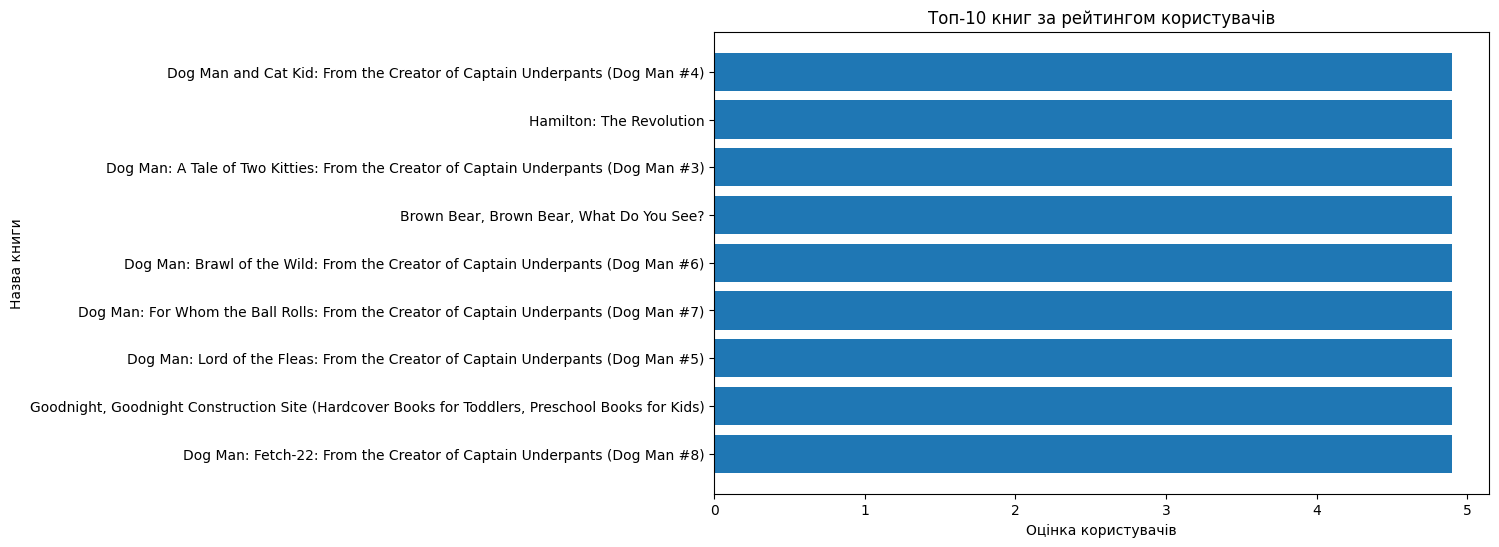

In [45]:
# Гістограма рейтингу 10 найкращих книг
import matplotlib.pyplot as plt

# Вибірка 10 книг з найвищим рейтингом
top_books = data.sort('user_rating', ascending=False).limit(10)

# Конвертація в Pandas DataFrame для візуалізації
top_books_pd = top_books.toPandas()

# Створення графіка
plt.figure(figsize=(10, 6))
plt.barh(top_books_pd['name'], top_books_pd['user_rating'])
plt.xlabel('Оцінка користувачів')
plt.ylabel('Назва книги')
plt.title('Топ-10 книг за рейтингом користувачів')
plt.gca().invert_yaxis()  # Для відображення книг з найвищим рейтингом на верху
plt.show()

In [46]:
# Матриця кореляції
data.select('user_rating', 'reviews', 'price').toPandas().corr()

,user_rating,reviews,price
user_rating,1.000000,-0.001729,-0.133086
reviews,-0.001729,1.000000,-0.109182
price,-0.133086,-0.109182,1.000000
